### This is my implementation of a homework in Sharif University of Technology that 1st- Compresses Single-cell RNA-Seq data to lower dimmension (using Normal and Denoising Autoencoder with different noise distributions like Zero-Inflated Negative Binomial) then drawing t-SNE plot of them. the Code is most like an ensemble of different codes from the internet but I don't know the exact references.

<b>Background</b>: 

Single-cell RNA-Seq (scRNA-Seq) data is incredibly noisy and sparse, with only a fraction of
transcribed RNAs captured in the sequencing due to the difficulty in amplifying such a small signal from a
single cell. Specifically, there are many genes expressed in a cell at any given time, and two entirely different
scRNA-Seq readings could come from cells with identical expression profiles.
In this assignment, you will explore utilizing autoencoders to identify clusters of cells from the counts data.
These clusters could represent varying expression profiles in the same tissue sample, such as the unique profiles
that you might see in different phases of the cell cycle or different cell types.


<b>Dataset</b>: 

 The data provided will be in the form of normalized log counts across 1000 genes
for 5000 cells provided for you in folder.

[dataset](https://drive.google.com/drive/folders/1zVHK09eZkjztrncyNQ_mgc31utsYSyf7?usp=sharing)



In [1]:
'''
please comment in your code each cell belongs to which question also put your final best 
weights in a drive and share its public path with us in jupyter notebook.
'''

#P1: Train an Autoencoder (composed of fully-connected layers) to learn a low-level gene expression
#representation of the cells from the scRNA-Seq counts

#P1_A:Use latent embedding (embedding learned by the bottleneck layer) sizes of 5, 10, 50, and 100. This is
#the size of the output of the encoder, and the input to the decoder. Also, follow the implementation notes

#P1_B:Report and compare the reconstruction Mean Squared Error (MSE) for each latent embedding size.
#How does the size of the latent space affect the reconstruction MSE?


#################
#################
#################


#P2: Analyze the learned encodings. produce PCA & t-SNE plots of the
#raw scRNA-Seq counts.

#P2_A:make PCA & t-SNE plots of the autoencoder reconstructions.

#P2_B:Compare and report the plots of the original data with the plots of the reconstructions. How do the
#PCA & t-SNE plots of the reconstructions compare with those of the original data?

#P2_C:Take the trained encoders of the previous autoencoders and make PCA & t-SNE plots of the latent
#embedding vectors. Remember to make and submit plots for all 4 autoencoders (latent embedding
#sizes - 5, 10, 50, and 100). How does the size of the latent space affect the latent vector plots?

#P2_D:Compare and report the plots of the original data and the plots of the latent vectors. How do the
#various embedding sizes change the quality of clustering?


#################
#################
#################

#P3:Convert your autoencoder to a denoising autoencoder. (Reconstruction loss is calculated using the original input without the added noise.)

#P3_A:Add Gaussian noise to the input data and train the denoising autoencoder to remove the added artifical
#noise.

#P3_B:Add negative binomial distribution (zero-inflated negative binomial) noise to the input data and train the
#denoising autoencoder to remove the added artificial noise.

#P3_C:For each of the above, compare and report the PCA plots of the original data and the plots of the latent
#vectors. Is the de-noising autoencoder able to remove the artificial noise in your data?

'\nplease comment in your code each cell belongs to which question also put your final best \nweights in a drive and share its public path with us in jupyter notebook.\n'

In [2]:
import os
import sys
import numpy as np
import argparse

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import torch
from torch import nn
from torch.utils.data import DataLoader
'''
Implementation Notes:
    Make sure to use a couple dropout layers to help prevent overfitting on this small dataset. No validation set is necessary for this task.
    For AE's, a good rule of thumb is to have the Encoder's architecture be symmetric to the Decoder's. (Ex. Enc=1000->100->10, Dec=10->100->1000)
    This assignment was tested with ~200 epochs. Your network may take more or less to produce some good clusters.

    For best results, you need to mask the outputs of the autoencoder that correspond to 0's (dropped counts) in the input.
    The autoencoder learns best when it is not forced to also learn to reconstruct the zeros in the input. This technique is known as gradient masking,
    and is commonly used in situations like this to prevent a training signal to reconstruct unimportant data.

    To acheive this, the reconstruction output of the autoencoder must be multiplied by a mask that zeros the corresponding
    dropped counts of the inputs, which ensures the gradient from that particular output is zero. Use MSE loss, and only average over
    the number of non-zero elements in the batch.

    Feel free to experiment with the size of the network, hyperparameters, and plotting parameters. More training information is better information!
'''




"\nImplementation Notes:\n    Make sure to use a couple dropout layers to help prevent overfitting on this small dataset. No validation set is necessary for this task.\n    For AE's, a good rule of thumb is to have the Encoder's architecture be symmetric to the Decoder's. (Ex. Enc=1000->100->10, Dec=10->100->1000)\n    This assignment was tested with ~200 epochs. Your network may take more or less to produce some good clusters.\n\n    For best results, you need to mask the outputs of the autoencoder that correspond to 0's (dropped counts) in the input.\n    The autoencoder learns best when it is not forced to also learn to reconstruct the zeros in the input. This technique is known as gradient masking,\n    and is commonly used in situations like this to prevent a training signal to reconstruct unimportant data.\n\n    To acheive this, the reconstruction output of the autoencoder must be multiplied by a mask that zeros the corresponding\n    dropped counts of the inputs, which ensures 

In [3]:
batch_size = 128
epochs = 200
learning_rate1 = 1e-3
random_seed = 42

In [4]:
data_x = np.load("counts.npy")
data_y = np.loadtxt("labels.txt")

data_x_tensor = torch.Tensor(data_x)
data_y_tensor = torch.Tensor(data_y)
# data_x_tensor_normalized = torch.nn.functional.normalize(data_x_tensor, p=1.0, dim = 1)
# data_y_tensor_normalized = torch.nn.functional.normalize(data_y_tensor, p=1.0, dim = 1)

dataset = torch.utils.data.TensorDataset(data_x_tensor, data_y_tensor)

dataset_train, dataset_test = torch.utils.data.random_split(dataset, [3500, 1500], generator=torch.Generator().manual_seed(random_seed))

dataset_train_loader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
dataset_test_loader = DataLoader(dataset_test, batch_size=batch_size, shuffle=True)

In [5]:
torch.manual_seed(random_seed)
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True

In [6]:
class AutoEncoder5(nn.Module):
    def __init__(self, **kwargs):
        super(AutoEncoder5, self).__init__()
        # self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Dropout(p=0.01),
            nn.Linear(100, 5),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Dropout(p=0.01),
            nn.Linear(5, 100),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(100, 1000),
            nn.ReLU()
        )

    def forward(self, x):
        # x = self.flatten(x)
        out1 = self.encoder(x)
        out2 = self.decoder(out1)
        return out1, out2


class AutoEncoder10(nn.Module):
    def __init__(self, **kwargs):
        super(AutoEncoder10, self).__init__()
        # self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Dropout(p=0.01),
            nn.Linear(100, 10),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Dropout(p=0.01),
            nn.Linear(10, 100),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(100, 1000),
            nn.ReLU()
        )

    def forward(self, x):
        # x = self.flatten(x)
        out1 = self.encoder(x)
        out2 = self.decoder(out1)
        return out1, out2


class AutoEncoder50(nn.Module):
    def __init__(self, **kwargs):
        super(AutoEncoder50, self).__init__()
        # self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Dropout(p=0.01),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Dropout(p=0.01),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(100, 1000),
            nn.ReLU()
        )

    def forward(self, x):
        # x = self.flatten(x)
        out1 = self.encoder(x)
        out2 = self.decoder(out1)
        return out1, out2


class AutoEncoder100(nn.Module):
    def __init__(self, **kwargs):
        super(AutoEncoder100, self).__init__()
        # self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Dropout(p=0.01),
            nn.Linear(500, 100),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Dropout(p=0.01),
            nn.Linear(100, 500),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(500, 1000),
            nn.ReLU()
        )

    def forward(self, x):
        # x = self.flatten(x)
        out1 = self.encoder(x)
        out2 = self.decoder(out1)
        return out1, out2

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model5 = AutoEncoder5(input_shape=1000).to(device)
model10 = AutoEncoder10(input_shape=1000).to(device)
model50 = AutoEncoder50(input_shape=1000).to(device)
model100 = AutoEncoder100(input_shape=1000).to(device)
optimizer5 = torch.optim.Adam(model5.parameters(), lr=learning_rate1, weight_decay=1e-5)
optimizer10 = torch.optim.Adam(model10.parameters(), lr=learning_rate1, weight_decay=1e-5)
optimizer50 = torch.optim.Adam(model50.parameters(), lr=learning_rate1, weight_decay=1e-5)
optimizer100 = torch.optim.Adam(model100.parameters(), lr=learning_rate1, weight_decay=1e-5)
criterion = nn.MSELoss()

In [8]:
#latent = 5
for epoch in range(epochs):
    loss = 0
    for batch_features, (data, label) in enumerate(dataset_train_loader):
        device_data = data.to(device)
        optimizer5.zero_grad()
        latent, out = model5(device_data)
        mask_index = device_data.ne(0)
        train_loss = criterion(out[mask_index], device_data[mask_index])
        train_loss.backward()
        optimizer5.step()
        loss += train_loss.item()
    loss = loss / len(dataset_train_loader)
    print("epoch : {}/{}, reconstruction loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/200, reconstruction loss = 11.10561204
epoch : 2/200, reconstruction loss = 2.38524636
epoch : 3/200, reconstruction loss = 1.46745234
epoch : 4/200, reconstruction loss = 1.10317465
epoch : 5/200, reconstruction loss = 0.94196831
epoch : 6/200, reconstruction loss = 0.81755937
epoch : 7/200, reconstruction loss = 0.75676828
epoch : 8/200, reconstruction loss = 0.71743894
epoch : 9/200, reconstruction loss = 0.69491146
epoch : 10/200, reconstruction loss = 0.65971014
epoch : 11/200, reconstruction loss = 0.63094880
epoch : 12/200, reconstruction loss = 0.56193899
epoch : 13/200, reconstruction loss = 0.51826279
epoch : 14/200, reconstruction loss = 0.50487352
epoch : 15/200, reconstruction loss = 0.49167053
epoch : 16/200, reconstruction loss = 0.48154277
epoch : 17/200, reconstruction loss = 0.48246784
epoch : 18/200, reconstruction loss = 0.46199576
epoch : 19/200, reconstruction loss = 0.45665637
epoch : 20/200, reconstruction loss = 0.46620846
epoch : 21/200, reconstructi

In [9]:
#laten = 10
for epoch in range(epochs):
    loss = 0
    for batch_features, (data, label) in enumerate(dataset_train_loader):
        device_data = data.to(device)
        optimizer10.zero_grad()
        latent, out = model10(device_data)
        mask_index = device_data.ne(0)
        train_loss = criterion(out[mask_index], device_data[mask_index])
        train_loss.backward()
        optimizer10.step()
        loss += train_loss.item()
    loss = loss / len(dataset_train_loader)
    print("epoch : {}/{}, reconstruction loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/200, reconstruction loss = 12.45526736
epoch : 2/200, reconstruction loss = 2.60475062
epoch : 3/200, reconstruction loss = 1.30413826
epoch : 4/200, reconstruction loss = 0.96541258
epoch : 5/200, reconstruction loss = 0.85435772
epoch : 6/200, reconstruction loss = 0.79479600
epoch : 7/200, reconstruction loss = 0.71380788
epoch : 8/200, reconstruction loss = 0.67827274
epoch : 9/200, reconstruction loss = 0.64705926
epoch : 10/200, reconstruction loss = 0.64665233
epoch : 11/200, reconstruction loss = 0.63421504
epoch : 12/200, reconstruction loss = 0.58661632
epoch : 13/200, reconstruction loss = 0.50551095
epoch : 14/200, reconstruction loss = 0.49369700
epoch : 15/200, reconstruction loss = 0.48845746
epoch : 16/200, reconstruction loss = 0.48497981
epoch : 17/200, reconstruction loss = 0.47723854
epoch : 18/200, reconstruction loss = 0.48694920
epoch : 19/200, reconstruction loss = 0.47550987
epoch : 20/200, reconstruction loss = 0.45879444
epoch : 21/200, reconstructi

In [10]:
#latent 50
for epoch in range(epochs):
    loss = 0
    for batch_features, (data, label) in enumerate(dataset_train_loader):
        device_data = data.to(device)
        optimizer50.zero_grad()
        latent, out = model50(device_data)
        mask_index = device_data.ne(0)
        train_loss = criterion(out[mask_index], device_data[mask_index])
        train_loss.backward()
        optimizer50.step()
        loss += train_loss.item()
    loss = loss / len(dataset_train_loader)
    print("epoch : {}/{}, reconstruction loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/200, reconstruction loss = 11.30110387
epoch : 2/200, reconstruction loss = 2.59791843
epoch : 3/200, reconstruction loss = 1.70648018
epoch : 4/200, reconstruction loss = 1.39924906
epoch : 5/200, reconstruction loss = 1.08233509
epoch : 6/200, reconstruction loss = 0.98359597
epoch : 7/200, reconstruction loss = 0.93265738
epoch : 8/200, reconstruction loss = 0.85331372
epoch : 9/200, reconstruction loss = 0.83577979
epoch : 10/200, reconstruction loss = 0.82275518
epoch : 11/200, reconstruction loss = 0.82627395
epoch : 12/200, reconstruction loss = 0.76418444
epoch : 13/200, reconstruction loss = 0.66730053
epoch : 14/200, reconstruction loss = 0.51612715
epoch : 15/200, reconstruction loss = 0.49482796
epoch : 16/200, reconstruction loss = 0.52646280
epoch : 17/200, reconstruction loss = 0.49543807
epoch : 18/200, reconstruction loss = 0.48013458
epoch : 19/200, reconstruction loss = 0.47736802
epoch : 20/200, reconstruction loss = 0.47625018
epoch : 21/200, reconstructi

In [11]:
#latent = 100
for epoch in range(epochs):
    loss = 0
    for batch_features, (data, label) in enumerate(dataset_train_loader):
        device_data = data.to(device)
        optimizer100.zero_grad()
        latent, out = model100(device_data)
        mask_index = device_data.ne(0)
        train_loss = criterion(out[mask_index], device_data[mask_index])
        train_loss.backward()
        optimizer100.step()
        loss += train_loss.item()
    loss = loss / len(dataset_train_loader)
    print("epoch : {}/{}, reconstruction loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/200, reconstruction loss = 5.68043799
epoch : 2/200, reconstruction loss = 1.25615261
epoch : 3/200, reconstruction loss = 0.62447488
epoch : 4/200, reconstruction loss = 0.48920132
epoch : 5/200, reconstruction loss = 0.46089746
epoch : 6/200, reconstruction loss = 0.45788575
epoch : 7/200, reconstruction loss = 0.46740127
epoch : 8/200, reconstruction loss = 0.44396519
epoch : 9/200, reconstruction loss = 0.41914572
epoch : 10/200, reconstruction loss = 0.41654771
epoch : 11/200, reconstruction loss = 0.41266643
epoch : 12/200, reconstruction loss = 0.42148471
epoch : 13/200, reconstruction loss = 0.41386476
epoch : 14/200, reconstruction loss = 0.40738013
epoch : 15/200, reconstruction loss = 0.40956975
epoch : 16/200, reconstruction loss = 0.41210232
epoch : 17/200, reconstruction loss = 0.42865482
epoch : 18/200, reconstruction loss = 0.40369837
epoch : 19/200, reconstruction loss = 0.38379056
epoch : 20/200, reconstruction loss = 0.37206540
epoch : 21/200, reconstructio

Based MSE(s) I can say that bigger latent layer means better MSE because we have more room to generate beeter result. And at the extreme if the size of latent is the size of input we just have a highway (at optimal case)

P2

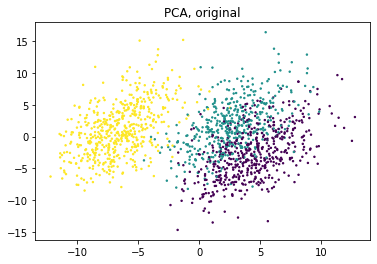

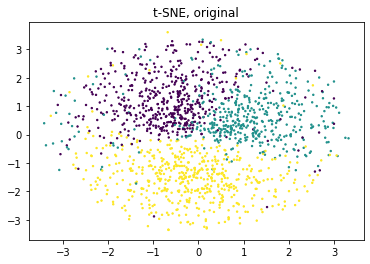

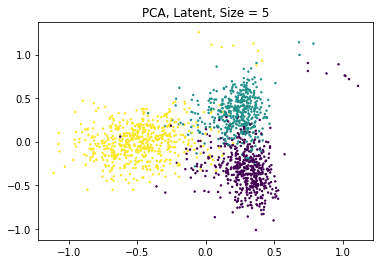

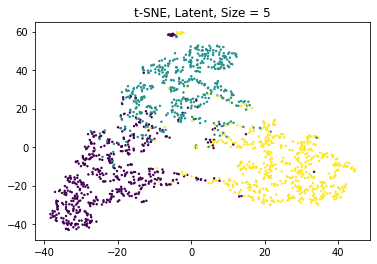

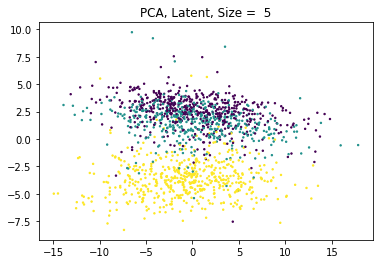

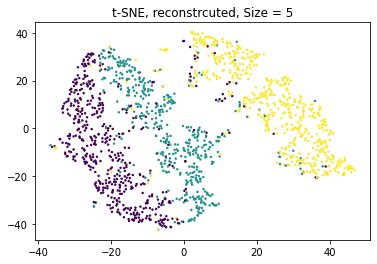

In [12]:
#Original, PCA and tSNE for model5
# dataset_loader = torch.utils.data.DataLoader(dataset)
dataset_test_loader_for_plot = DataLoader(dataset_test)
data_x_out = []
data_x_in = []
data_x_latent = []
data_y_out = []
with torch.no_grad():
    for _, (x, label) in enumerate(dataset_test_loader_for_plot):
        data_x_in.append(x)
        data_y_out.append(int(label))
        data_x_latent.append(model5(x)[0])
        data_x_out.append(model5(x)[1])
original_data = np.array([data_x_in[i].cpu().detach().numpy()[0] for i in range(len(data_x_in))])
encoded_data = np.array([data_x_latent[i].cpu().detach().numpy()[0] for i in range(len(data_x_latent))])
recosntructed_data = np.array([data_x_out[i].cpu().detach().numpy()[0] for i in range(len(data_x_out))])

#PCA for original
pca = PCA(n_components=2)
original_data_pca = pca.fit_transform(original_data)
plt.scatter(original_data_pca[:,0], original_data_pca[:,1], c=data_y_out, s=2)
plt.title('PCA, original')
plt.show()

#tSNE for original
original_data_tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=random_seed).fit_transform(original_data)
plt.scatter(original_data_tsne[:,0], original_data_tsne[:,1], c=data_y_out , s=2)
plt.title('t-SNE, original')
plt.show()

#PCA for encoded
pca = PCA(n_components=2)
encoded_pca_data = pca.fit_transform(encoded_data)
plt.scatter(encoded_pca_data[:,0], encoded_pca_data[:,1], c=data_y_out, s=2)
plt.title('PCA, Latent, Size = 5')
plt.show()

#tSNE for encoded
encoded_tsne_latent = TSNE(n_components=2, learning_rate='auto', init='random', random_state=random_seed).fit_transform(encoded_data)
plt.scatter(encoded_tsne_latent[:,0], encoded_tsne_latent[:,1], c=data_y_out , s=2)
plt.title('t-SNE, Latent, Size = 5')
plt.show()

#PCA for reconstructed
pca = PCA(n_components=2)
reconstructed_pca_data = pca.fit_transform(recosntructed_data)
plt.scatter(reconstructed_pca_data[:,0], reconstructed_pca_data[:,1], c=data_y_out, s=2)
plt.title('PCA, Latent, Size =  5')
plt.show()


#tSNE for reconstructed
reconstructed_tsne_latent = TSNE(n_components=2, learning_rate='auto', init='random', random_state=random_seed).fit_transform(recosntructed_data)
plt.scatter(reconstructed_tsne_latent[:,0], reconstructed_tsne_latent[:,1], c=data_y_out , s=2)
plt.title('t-SNE, reconstrcuted, Size = 5')
plt.show()

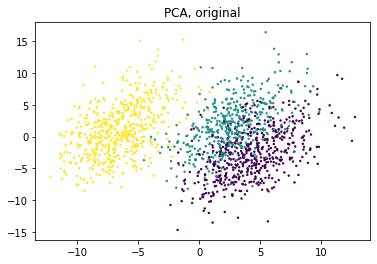

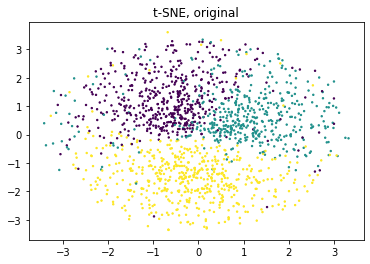

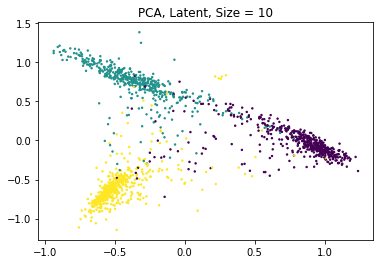

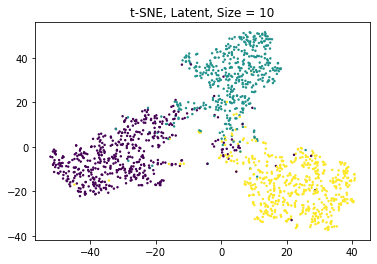

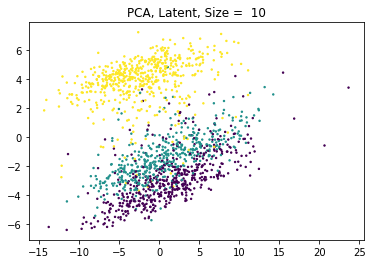

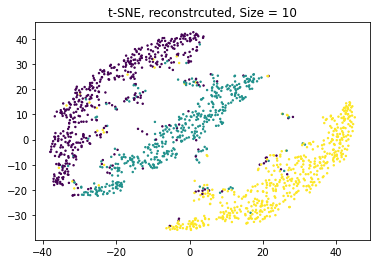

In [13]:
#Original, PCA and tSNE for model10
# dataset_loader = torch.utils.data.DataLoader(dataset)
dataset_test_loader_for_plot = DataLoader(dataset_test)
data_x_out = []
data_x_in = []
data_x_latent = []
data_y_out = []
with torch.no_grad():
    for _, (x, label) in enumerate(dataset_test_loader_for_plot):
        data_x_in.append(x)
        data_y_out.append(int(label))
        data_x_latent.append(model10(x)[0])
        data_x_out.append(model10(x)[1])
original_data = np.array([data_x_in[i].cpu().detach().numpy()[0] for i in range(len(data_x_in))])
encoded_data = np.array([data_x_latent[i].cpu().detach().numpy()[0] for i in range(len(data_x_latent))])
recosntructed_data = np.array([data_x_out[i].cpu().detach().numpy()[0] for i in range(len(data_x_out))])

#PCA for original
pca = PCA(n_components=2)
original_data_pca = pca.fit_transform(original_data)
plt.scatter(original_data_pca[:,0], original_data_pca[:,1], c=data_y_out, s=2)
plt.title(f'PCA, original')
plt.show()

#tSNE for original
original_data_tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=random_seed).fit_transform(original_data)
plt.scatter(original_data_tsne[:,0], original_data_tsne[:,1], c=data_y_out , s=2)
plt.title(f't-SNE, original')
plt.show()

#PCA for encoded
pca = PCA(n_components=2)
encoded_pca_data = pca.fit_transform(encoded_data)
plt.scatter(encoded_pca_data[:,0], encoded_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, Latent, Size = 10')
plt.show()

#tSNE for encoded
encoded_tsne_latent = TSNE(n_components=2, learning_rate='auto', init='random', random_state=random_seed).fit_transform(encoded_data)
plt.scatter(encoded_tsne_latent[:,0], encoded_tsne_latent[:,1], c=data_y_out , s=2)
plt.title(f't-SNE, Latent, Size = 10')
plt.show()

#PCA for reconstructed
pca = PCA(n_components=2)
reconstructed_pca_data = pca.fit_transform(recosntructed_data)
plt.scatter(reconstructed_pca_data[:,0], reconstructed_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, Latent, Size =  10')
plt.show()


#tSNE for reconstructed
reconstructed_tsne_latent = TSNE(n_components=2, learning_rate='auto', init='random', random_state=random_seed).fit_transform(recosntructed_data)
plt.scatter(reconstructed_tsne_latent[:,0], reconstructed_tsne_latent[:,1], c=data_y_out , s=2)
plt.title(f't-SNE, reconstrcuted, Size = 10')
plt.show()

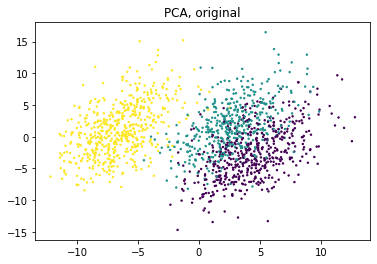

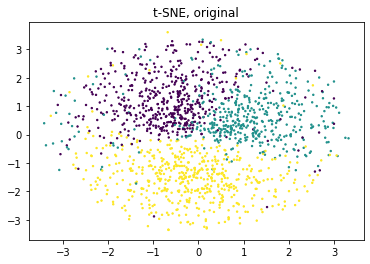

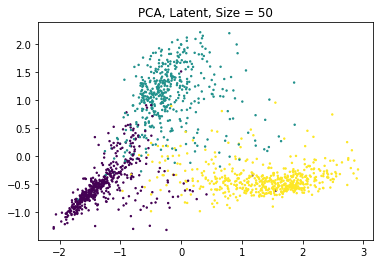

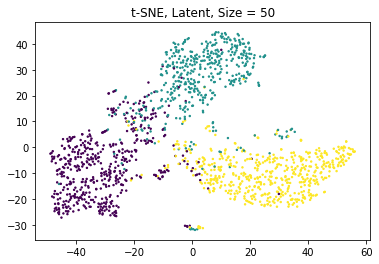

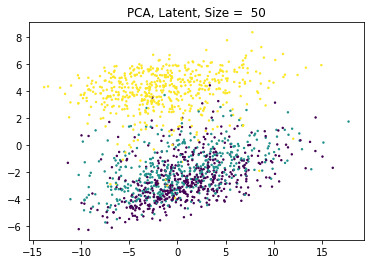

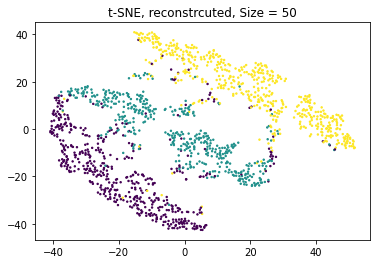

In [14]:
#Original, PCA and tSNE for model50
# dataset_loader = torch.utils.data.DataLoader(dataset)
dataset_test_loader_for_plot = DataLoader(dataset_test)
data_x_out = []
data_x_in = []
data_x_latent = []
data_y_out = []
with torch.no_grad():
    for _, (x, label) in enumerate(dataset_test_loader_for_plot):
        data_x_in.append(x)
        data_y_out.append(int(label))
        data_x_latent.append(model50(x)[0])
        data_x_out.append(model50(x)[1])
original_data = np.array([data_x_in[i].cpu().detach().numpy()[0] for i in range(len(data_x_in))])
encoded_data = np.array([data_x_latent[i].cpu().detach().numpy()[0] for i in range(len(data_x_latent))])
recosntructed_data = np.array([data_x_out[i].cpu().detach().numpy()[0] for i in range(len(data_x_out))])

#PCA for original
pca = PCA(n_components=2)
original_data_pca = pca.fit_transform(original_data)
plt.scatter(original_data_pca[:,0], original_data_pca[:,1], c=data_y_out, s=2)
plt.title(f'PCA, original')
plt.show()

#tSNE for original
original_data_tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=random_seed).fit_transform(original_data)
plt.scatter(original_data_tsne[:,0], original_data_tsne[:,1], c=data_y_out , s=2)
plt.title(f't-SNE, original')
plt.show()

#PCA for encoded
pca = PCA(n_components=2)
encoded_pca_data = pca.fit_transform(encoded_data)
plt.scatter(encoded_pca_data[:,0], encoded_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, Latent, Size = 50')
plt.show()

#tSNE for encoded
encoded_tsne_latent = TSNE(n_components=2, learning_rate='auto', init='random', random_state=random_seed).fit_transform(encoded_data)
plt.scatter(encoded_tsne_latent[:,0], encoded_tsne_latent[:,1], c=data_y_out , s=2)
plt.title(f't-SNE, Latent, Size = 50')
plt.show()

#PCA for reconstructed
pca = PCA(n_components=2)
reconstructed_pca_data = pca.fit_transform(recosntructed_data)
plt.scatter(reconstructed_pca_data[:,0], reconstructed_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, Latent, Size =  50')
plt.show()


#tSNE for reconstructed
reconstructed_tsne_latent = TSNE(n_components=2, learning_rate='auto', init='random', random_state=random_seed).fit_transform(recosntructed_data)
plt.scatter(reconstructed_tsne_latent[:,0], reconstructed_tsne_latent[:,1], c=data_y_out , s=2)
plt.title(f't-SNE, reconstrcuted, Size = 50')
plt.show()

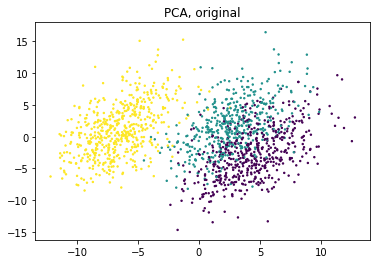

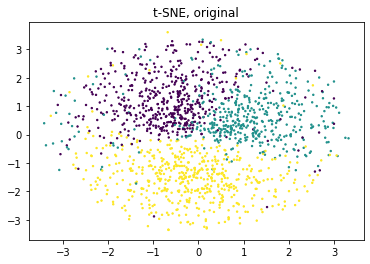

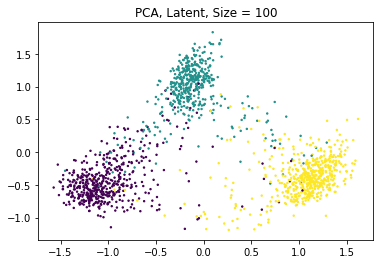

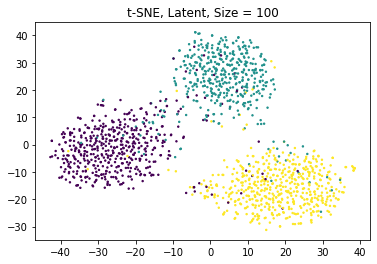

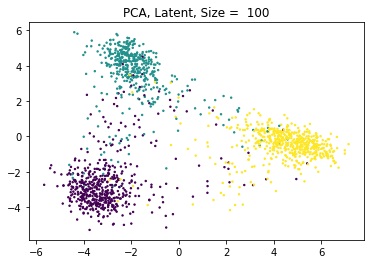

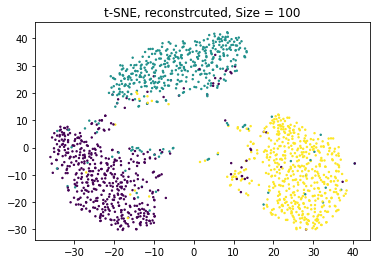

In [15]:
#Original, PCA and tSNE for model100
dataset_test_loader_for_plot = DataLoader(dataset_test)
data_x_out = []
data_x_in = []
data_x_latent = []
data_y_out = []
with torch.no_grad():
    for _, (x, label) in enumerate(dataset_test_loader_for_plot):
        data_x_in.append(x)
        data_y_out.append(int(label))
        data_x_latent.append(model100(x)[0])
        data_x_out.append(model100(x)[1])
original_data = np.array([data_x_in[i].cpu().detach().numpy()[0] for i in range(len(data_x_in))])
encoded_data = np.array([data_x_latent[i].cpu().detach().numpy()[0] for i in range(len(data_x_latent))])
recosntructed_data = np.array([data_x_out[i].cpu().detach().numpy()[0] for i in range(len(data_x_out))])

#PCA for original
pca = PCA(n_components=2)
original_data_pca = pca.fit_transform(original_data)
plt.scatter(original_data_pca[:,0], original_data_pca[:,1], c=data_y_out, s=2)
plt.title(f'PCA, original')
plt.show()

#tSNE for original
original_data_tsne = TSNE(n_components=2, learning_rate='auto', init='random', random_state=random_seed).fit_transform(original_data)
plt.scatter(original_data_tsne[:,0], original_data_tsne[:,1], c=data_y_out , s=2)
plt.title(f't-SNE, original')
plt.show()

#PCA for encoded
pca = PCA(n_components=2)
encoded_pca_data = pca.fit_transform(encoded_data)
plt.scatter(encoded_pca_data[:,0], encoded_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, Latent, Size = 100')
plt.show()

#tSNE for encoded
encoded_tsne_latent = TSNE(n_components=2, learning_rate='auto', init='random', random_state=random_seed).fit_transform(encoded_data)
plt.scatter(encoded_tsne_latent[:,0], encoded_tsne_latent[:,1], c=data_y_out , s=2)
plt.title(f't-SNE, Latent, Size = 100')
plt.show()

#PCA for reconstructed
pca = PCA(n_components=2)
reconstructed_pca_data = pca.fit_transform(recosntructed_data)
plt.scatter(reconstructed_pca_data[:,0], reconstructed_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, Latent, Size =  100')
plt.show()


#tSNE for reconstructed
reconstructed_tsne_latent = TSNE(n_components=2, learning_rate='auto', init='random', random_state=random_seed).fit_transform(recosntructed_data)
plt.scatter(reconstructed_tsne_latent[:,0], reconstructed_tsne_latent[:,1], c=data_y_out , s=2)
plt.title(f't-SNE, reconstrcuted, Size = 100')
plt.show()

Based on All the plots I cansay that both tSNE and PCA for recusntructed has better clustering results than the orginal one and and latent ones have good clustering too.

P3

In [16]:
class Denoising_AutoEncoder5(nn.Module):
    def __init__(self, **kwargs):
        super(Denoising_AutoEncoder5, self).__init__()
        # self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Dropout(p=0.01),
            nn.Linear(100, 5),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Dropout(p=0.01),
            nn.Linear(5, 100),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(100, 1000),
            nn.ReLU()
        )

    def forward(self, x):
        # x = self.flatten(x)
        out1 = self.encoder(x)
        out2 = self.decoder(out1)
        return out1, out2


class Denoising_AutoEncoder10(nn.Module):
    def __init__(self, **kwargs):
        super(Denoising_AutoEncoder10, self).__init__()
        # self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Dropout(p=0.01),
            nn.Linear(100, 10),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Dropout(p=0.01),
            nn.Linear(10, 100),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(100, 1000),
            nn.ReLU()
        )

    def forward(self, x):
        # x = self.flatten(x)
        out1 = self.encoder(x)
        out2 = self.decoder(out1)
        return out1, out2


class Denoising_AutoEncoder50(nn.Module):
    def __init__(self, **kwargs):
        super(Denoising_AutoEncoder50, self).__init__()
        # self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Dropout(p=0.01),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Dropout(p=0.01),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(100, 1000),
            nn.ReLU()
        )

    def forward(self, x):
        # x = self.flatten(x)
        out1 = self.encoder(x)
        out2 = self.decoder(out1)
        return out1, out2


class Denoising_AutoEncoder100(nn.Module):
    def __init__(self, **kwargs):
        super(Denoising_AutoEncoder100, self).__init__()
        # self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Dropout(p=0.01),
            nn.Linear(100, 100),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Dropout(p=0.01),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(100, 1000),
            nn.ReLU()
        )

    def forward(self, x):
        # x = self.flatten(x)
        out1 = self.encoder(x)
        out2 = self.decoder(out1)
        return out1, out2

In [17]:
denoising_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
denoising_model5 = Denoising_AutoEncoder5(input_shape=1000).to(denoising_device)
denoising_model10 = Denoising_AutoEncoder10(input_shape=1000).to(denoising_device)
denoising_model50 = Denoising_AutoEncoder50(input_shape=1000).to(denoising_device)
denoising_model100 = Denoising_AutoEncoder100(input_shape=1000).to(denoising_device)
denoising_optimizer5 = torch.optim.Adam(denoising_model5.parameters(), lr=learning_rate1, weight_decay=1e-5)
denoising_optimizer10 = torch.optim.Adam(denoising_model10.parameters(), lr=learning_rate1, weight_decay=1e-5)
denoising_optimizer50 = torch.optim.Adam(denoising_model50.parameters(), lr=learning_rate1, weight_decay=1e-5)
denoising_optimizer100 = torch.optim.Adam(denoising_model100.parameters(), lr=learning_rate1, weight_decay=1e-5)
denoising_criterion = nn.MSELoss()

In [18]:
#denoising, latent = 5
noisys = []
for epoch in range(epochs):
    loss = 0
    for batch_features, (data, label) in enumerate(dataset_train_loader):
        device_data = data.to(denoising_device)
        mask_index = device_data.ne(0)
        # device_data[mask_index] +=  torch.randn(device_data.shape)[mask_index]
        device_data_noisy_guassian = device_data + torch.randn(device_data.shape)
        denoising_optimizer5.zero_grad()
        latent, out = denoising_model5(device_data_noisy_guassian)
        # train_loss = denoising_criterion(out[mask_index], device_data[mask_index])
        train_loss = denoising_criterion(out[mask_index], device_data[mask_index])
        train_loss.backward()
        denoising_optimizer5.step()
        loss += train_loss.item()
    loss = loss / len(dataset_train_loader)
    print("epoch : {}/{}, reconstruction loss = {:.8f}".format(epoch + 1, epochs, loss))
    


epoch : 1/200, reconstruction loss = 11.75539306
epoch : 2/200, reconstruction loss = 2.96561124
epoch : 3/200, reconstruction loss = 1.84422697
epoch : 4/200, reconstruction loss = 1.47947908
epoch : 5/200, reconstruction loss = 1.27117100
epoch : 6/200, reconstruction loss = 1.02602642
epoch : 7/200, reconstruction loss = 0.89491887
epoch : 8/200, reconstruction loss = 0.79755556
epoch : 9/200, reconstruction loss = 0.73776697
epoch : 10/200, reconstruction loss = 0.69822007
epoch : 11/200, reconstruction loss = 0.64463042
epoch : 12/200, reconstruction loss = 0.59657580
epoch : 13/200, reconstruction loss = 0.53638756
epoch : 14/200, reconstruction loss = 0.53343226
epoch : 15/200, reconstruction loss = 0.54603923
epoch : 16/200, reconstruction loss = 0.52678932
epoch : 17/200, reconstruction loss = 0.51810592
epoch : 18/200, reconstruction loss = 0.51705068
epoch : 19/200, reconstruction loss = 0.49589499
epoch : 20/200, reconstruction loss = 0.48709342
epoch : 21/200, reconstructi

In [19]:
#denoising, latent = 10
noisys = []
for epoch in range(epochs):
    loss = 0
    for batch_features, (data, label) in enumerate(dataset_train_loader):
        device_data = data.to(denoising_device)
        mask_index = device_data.ne(0)
        # device_data[mask_index] +=  torch.randn(device_data.shape)[mask_index]
        device_data_noisy_guassian = device_data + torch.randn(device_data.shape)
        denoising_optimizer10.zero_grad()
        latent, out = denoising_model10(device_data_noisy_guassian)
        # train_loss = denoising_criterion(out[mask_index], device_data[mask_index])
        train_loss = denoising_criterion(out[mask_index], device_data[mask_index])
        train_loss.backward()
        denoising_optimizer10.step()
        loss += train_loss.item()
    loss = loss / len(dataset_train_loader)
    print("epoch : {}/{}, reconstruction loss = {:.8f}".format(epoch + 1, epochs, loss))
    


epoch : 1/200, reconstruction loss = 11.43452825
epoch : 2/200, reconstruction loss = 3.02106185
epoch : 3/200, reconstruction loss = 1.97802792
epoch : 4/200, reconstruction loss = 1.53049143
epoch : 5/200, reconstruction loss = 1.27543963
epoch : 6/200, reconstruction loss = 1.18676881
epoch : 7/200, reconstruction loss = 1.04487842
epoch : 8/200, reconstruction loss = 1.01140899
epoch : 9/200, reconstruction loss = 0.93057924
epoch : 10/200, reconstruction loss = 0.76160726
epoch : 11/200, reconstruction loss = 0.62892415
epoch : 12/200, reconstruction loss = 0.56401455
epoch : 13/200, reconstruction loss = 0.50946468
epoch : 14/200, reconstruction loss = 0.49063547
epoch : 15/200, reconstruction loss = 0.49409025
epoch : 16/200, reconstruction loss = 0.48525665
epoch : 17/200, reconstruction loss = 0.48102543
epoch : 18/200, reconstruction loss = 0.46643510
epoch : 19/200, reconstruction loss = 0.46626127
epoch : 20/200, reconstruction loss = 0.45572779
epoch : 21/200, reconstructi

In [20]:
#denoising, latent = 50
noisys = []
for epoch in range(epochs):
    loss = 0
    for batch_features, (data, label) in enumerate(dataset_train_loader):
        device_data = data.to(denoising_device)
        mask_index = device_data.ne(0)
        # device_data[mask_index] +=  torch.randn(device_data.shape)[mask_index]
        device_data_noisy_guassian = device_data + torch.randn(device_data.shape)
        denoising_optimizer50.zero_grad()
        latent, out = denoising_model50(device_data_noisy_guassian)
        # train_loss = denoising_criterion(out[mask_index], device_data[mask_index])
        train_loss = denoising_criterion(out[mask_index], device_data[mask_index])
        train_loss.backward()
        denoising_optimizer50.step()
        loss += train_loss.item()
    loss = loss / len(dataset_train_loader)
    print("epoch : {}/{}, reconstruction loss = {:.8f}".format(epoch + 1, epochs, loss))
    


epoch : 1/200, reconstruction loss = 11.92371293
epoch : 2/200, reconstruction loss = 3.36793120
epoch : 3/200, reconstruction loss = 2.26149656
epoch : 4/200, reconstruction loss = 1.82084327
epoch : 5/200, reconstruction loss = 1.66099316
epoch : 6/200, reconstruction loss = 1.38006116
epoch : 7/200, reconstruction loss = 1.13959755
epoch : 8/200, reconstruction loss = 1.02890001
epoch : 9/200, reconstruction loss = 0.79448770
epoch : 10/200, reconstruction loss = 0.66727777
epoch : 11/200, reconstruction loss = 0.57280162
epoch : 12/200, reconstruction loss = 0.54508605
epoch : 13/200, reconstruction loss = 0.50112172
epoch : 14/200, reconstruction loss = 0.51985631
epoch : 15/200, reconstruction loss = 0.49713167
epoch : 16/200, reconstruction loss = 0.48170125
epoch : 17/200, reconstruction loss = 0.47468304
epoch : 18/200, reconstruction loss = 0.48510742
epoch : 19/200, reconstruction loss = 0.48897340
epoch : 20/200, reconstruction loss = 0.46796388
epoch : 21/200, reconstructi

In [21]:
#denoising, latent = 100
noisys = []
for epoch in range(epochs):
    loss = 0
    for batch_features, (data, label) in enumerate(dataset_train_loader):
        device_data = data.to(denoising_device)
        mask_index = device_data.ne(0)
        # device_data[mask_index] +=  torch.randn(device_data.shape)[mask_index]
        device_data_noisy_guassian = device_data + torch.randn(device_data.shape)
        denoising_optimizer100.zero_grad()
        latent, out = denoising_model100(device_data_noisy_guassian)
        # train_loss = denoising_criterion(out[mask_index], device_data[mask_index])
        train_loss = denoising_criterion(out[mask_index], device_data[mask_index])
        train_loss.backward()
        denoising_optimizer100.step()
        loss += train_loss.item()
    loss = loss / len(dataset_train_loader)
    print("epoch : {}/{}, reconstruction loss = {:.8f}".format(epoch + 1, epochs, loss))
    


epoch : 1/200, reconstruction loss = 11.42282847
epoch : 2/200, reconstruction loss = 2.33562145
epoch : 3/200, reconstruction loss = 1.35131422
epoch : 4/200, reconstruction loss = 1.13783383
epoch : 5/200, reconstruction loss = 0.96904619
epoch : 6/200, reconstruction loss = 0.91018310
epoch : 7/200, reconstruction loss = 0.86673049
epoch : 8/200, reconstruction loss = 0.80135621
epoch : 9/200, reconstruction loss = 0.78533678
epoch : 10/200, reconstruction loss = 0.74463303
epoch : 11/200, reconstruction loss = 0.63057124
epoch : 12/200, reconstruction loss = 0.58610178
epoch : 13/200, reconstruction loss = 0.53017435
epoch : 14/200, reconstruction loss = 0.51006800
epoch : 15/200, reconstruction loss = 0.50591235
epoch : 16/200, reconstruction loss = 0.50279469
epoch : 17/200, reconstruction loss = 0.49669913
epoch : 18/200, reconstruction loss = 0.49323238
epoch : 19/200, reconstruction loss = 0.48121533
epoch : 20/200, reconstruction loss = 0.49542827
epoch : 21/200, reconstructi

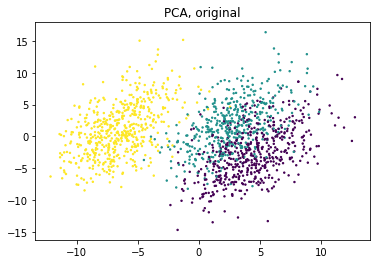

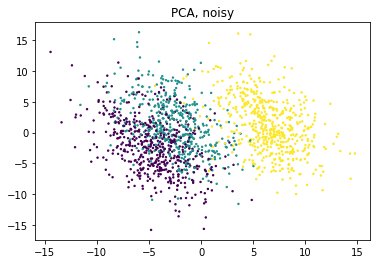

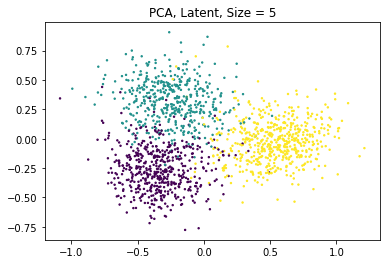

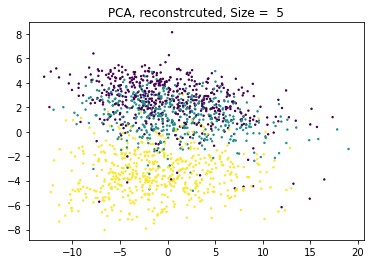

In [22]:
#Original, noisy, PCA, tSNE for denoising_model5
dataset_test_loader_for_plot = DataLoader(dataset_test)
data_x_out = []
data_x_in = []
data_x_latent = []
data_y_out = []
data_noisy = []
with torch.no_grad():
    for _, (x, label) in enumerate(dataset_test_loader_for_plot):
        data_x_in.append(x)
        data_y_out.append(int(label))
        data_x_latent.append(denoising_model5(x)[0])
        data_x_out.append(denoising_model5(x)[1])
          
original_data = np.array([data_x_in[i].cpu().detach().numpy()[0] for i in range(len(data_x_in))])
data_noisy = torch.tensor(original_data) + torch.randn(original_data.shape)
encoded_data = np.array([data_x_latent[i].cpu().detach().numpy()[0] for i in range(len(data_x_latent))])
recosntructed_data = np.array([data_x_out[i].cpu().detach().numpy()[0] for i in range(len(data_x_out))])


#PCA for original
pca = PCA(n_components=2)
original_data_pca = pca.fit_transform(original_data)
plt.scatter(original_data_pca[:,0], original_data_pca[:,1], c=data_y_out, s=2)
plt.title(f'PCA, original')
plt.show()

#PCA for noisy
pca = PCA(n_components=2)
data_noisy_pca = pca.fit_transform(data_noisy)
plt.scatter(data_noisy_pca[:,0], data_noisy_pca[:,1], c=data_y_out, s=2)
plt.title(f'PCA, noisy')
plt.show()

#PCA for encoded
pca = PCA(n_components=2)
encoded_pca_data = pca.fit_transform(encoded_data)
plt.scatter(encoded_pca_data[:,0], encoded_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, Latent, Size = 5')
plt.show()

#PCA for reconstructed
pca = PCA(n_components=2)
reconstructed_pca_data = pca.fit_transform(recosntructed_data)
plt.scatter(reconstructed_pca_data[:,0], reconstructed_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, reconstrcuted, Size =  5')
plt.show()

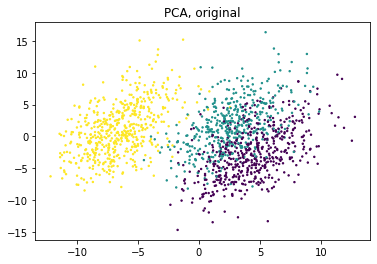

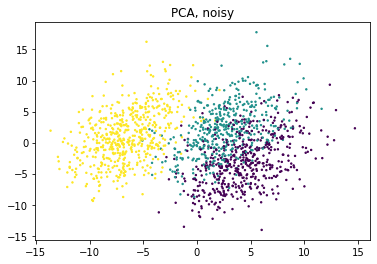

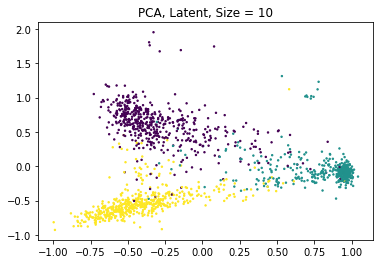

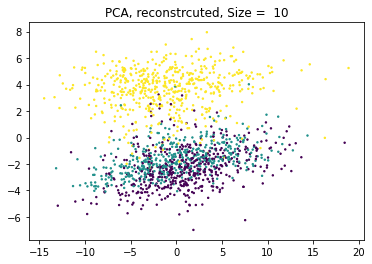

In [23]:
#Original, noisy, PCA, tSNE for denoising_model10
dataset_test_loader_for_plot = DataLoader(dataset_test)
data_x_out = []
data_x_in = []
data_x_latent = []
data_y_out = []
data_noisy = []
with torch.no_grad():
    for _, (x, label) in enumerate(dataset_test_loader_for_plot):
        data_x_in.append(x)
        data_y_out.append(int(label))
        data_x_latent.append(denoising_model10(x)[0])
        data_x_out.append(denoising_model10(x)[1])
          
original_data = np.array([data_x_in[i].cpu().detach().numpy()[0] for i in range(len(data_x_in))])
data_noisy = torch.tensor(original_data) + torch.randn(original_data.shape)
encoded_data = np.array([data_x_latent[i].cpu().detach().numpy()[0] for i in range(len(data_x_latent))])
recosntructed_data = np.array([data_x_out[i].cpu().detach().numpy()[0] for i in range(len(data_x_out))])


#PCA for original
pca = PCA(n_components=2)
original_data_pca = pca.fit_transform(original_data)
plt.scatter(original_data_pca[:,0], original_data_pca[:,1], c=data_y_out, s=2)
plt.title(f'PCA, original')
plt.show()

#PCA for noisy
pca = PCA(n_components=2)
data_noisy_pca = pca.fit_transform(data_noisy)
plt.scatter(data_noisy_pca[:,0], data_noisy_pca[:,1], c=data_y_out, s=2)
plt.title(f'PCA, noisy')
plt.show()

#PCA for encoded
pca = PCA(n_components=2)
encoded_pca_data = pca.fit_transform(encoded_data)
plt.scatter(encoded_pca_data[:,0], encoded_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, Latent, Size = 10')
plt.show()

#PCA for reconstructed
pca = PCA(n_components=2)
reconstructed_pca_data = pca.fit_transform(recosntructed_data)
plt.scatter(reconstructed_pca_data[:,0], reconstructed_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, reconstrcuted, Size =  10')
plt.show()

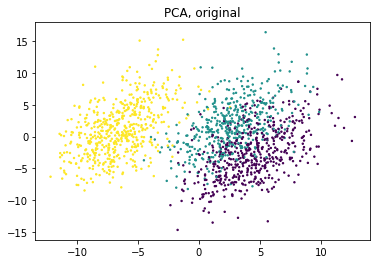

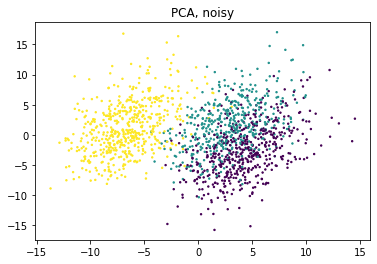

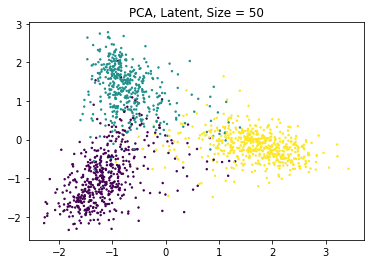

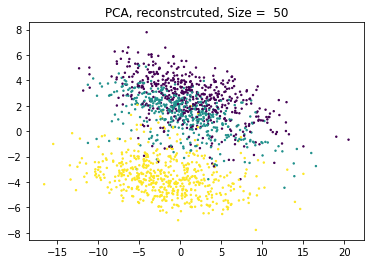

In [24]:
#Original, noisy, PCA, tSNE for denoising_model50
dataset_test_loader_for_plot = DataLoader(dataset_test)
data_x_out = []
data_x_in = []
data_x_latent = []
data_y_out = []
data_noisy = []
with torch.no_grad():
    for _, (x, label) in enumerate(dataset_test_loader_for_plot):
        data_x_in.append(x)
        data_y_out.append(int(label))
        data_x_latent.append(denoising_model50(x)[0])
        data_x_out.append(denoising_model50(x)[1])
          
original_data = np.array([data_x_in[i].cpu().detach().numpy()[0] for i in range(len(data_x_in))])
data_noisy = torch.tensor(original_data) + torch.randn(original_data.shape)
encoded_data = np.array([data_x_latent[i].cpu().detach().numpy()[0] for i in range(len(data_x_latent))])
recosntructed_data = np.array([data_x_out[i].cpu().detach().numpy()[0] for i in range(len(data_x_out))])


#PCA for original
pca = PCA(n_components=2)
original_data_pca = pca.fit_transform(original_data)
plt.scatter(original_data_pca[:,0], original_data_pca[:,1], c=data_y_out, s=2)
plt.title(f'PCA, original')
plt.show()

#PCA for noisy
pca = PCA(n_components=2)
data_noisy_pca = pca.fit_transform(data_noisy)
plt.scatter(data_noisy_pca[:,0], data_noisy_pca[:,1], c=data_y_out, s=2)
plt.title(f'PCA, noisy')
plt.show()

#PCA for encoded
pca = PCA(n_components=2)
encoded_pca_data = pca.fit_transform(encoded_data)
plt.scatter(encoded_pca_data[:,0], encoded_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, Latent, Size = 50')
plt.show()

#PCA for reconstructed
pca = PCA(n_components=2)
reconstructed_pca_data = pca.fit_transform(recosntructed_data)
plt.scatter(reconstructed_pca_data[:,0], reconstructed_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, reconstrcuted, Size =  50')
plt.show()

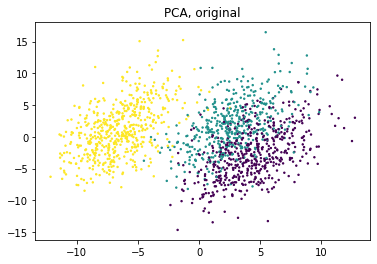

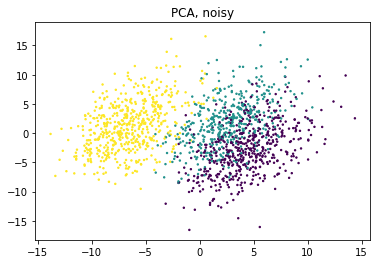

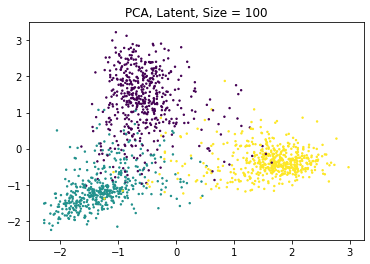

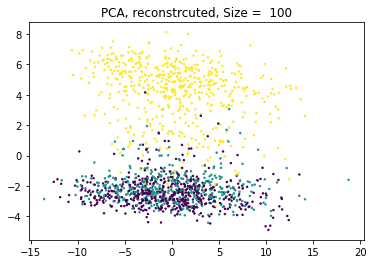

In [25]:
#Original, noisy, PCA, tSNE for denoising_model100
dataset_test_loader_for_plot = DataLoader(dataset_test)
data_x_out = []
data_x_in = []
data_x_latent = []
data_y_out = []
data_noisy = []
with torch.no_grad():
    for _, (x, label) in enumerate(dataset_test_loader_for_plot):
        data_x_in.append(x)
        data_y_out.append(int(label))
        data_x_latent.append(denoising_model100(x)[0])
        data_x_out.append(denoising_model100(x)[1])
          
original_data = np.array([data_x_in[i].cpu().detach().numpy()[0] for i in range(len(data_x_in))])
data_noisy = torch.tensor(original_data) + torch.randn(original_data.shape)
encoded_data = np.array([data_x_latent[i].cpu().detach().numpy()[0] for i in range(len(data_x_latent))])
recosntructed_data = np.array([data_x_out[i].cpu().detach().numpy()[0] for i in range(len(data_x_out))])


#PCA for original
pca = PCA(n_components=2)
original_data_pca = pca.fit_transform(original_data)
plt.scatter(original_data_pca[:,0], original_data_pca[:,1], c=data_y_out, s=2)
plt.title(f'PCA, original')
plt.show()

#PCA for noisy
pca = PCA(n_components=2)
data_noisy_pca = pca.fit_transform(data_noisy)
plt.scatter(data_noisy_pca[:,0], data_noisy_pca[:,1], c=data_y_out, s=2)
plt.title(f'PCA, noisy')
plt.show()

#PCA for encoded
pca = PCA(n_components=2)
encoded_pca_data = pca.fit_transform(encoded_data)
plt.scatter(encoded_pca_data[:,0], encoded_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, Latent, Size = 100')
plt.show()

#PCA for reconstructed
pca = PCA(n_components=2)
reconstructed_pca_data = pca.fit_transform(recosntructed_data)
plt.scatter(reconstructed_pca_data[:,0], reconstructed_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, reconstrcuted, Size =  100')
plt.show()

In [26]:
def ZINB(zero_probabilty, distribution_total_count,distribution_probability, linear_size):
    return torch.distributions.negative_binomial.NegativeBinomial(distribution_total_count, probs=distribution_probability, logits=None, validate_args=None).sample_n(linear_size) * torch.distributions.bernoulli.Bernoulli(probs=1 - zero_probabilty).sample_n(linear_size)

In [27]:
class ZINB_Denoising_AutoEncoder5(nn.Module):
    def __init__(self, **kwargs):
        super(ZINB_Denoising_AutoEncoder5, self).__init__()
        # self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Dropout(p=0.01),
            nn.Linear(100, 5),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Dropout(p=0.01),
            nn.Linear(5, 100),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(100, 1000),
            nn.ReLU()
        )

    def forward(self, x):
        # x = self.flatten(x)
        out1 = self.encoder(x)
        out2 = self.decoder(out1)
        return out1, out2


class ZINB_Denoising_AutoEncoder10(nn.Module):
    def __init__(self, **kwargs):
        super(ZINB_Denoising_AutoEncoder10, self).__init__()
        # self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Dropout(p=0.01),
            nn.Linear(100, 10),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Dropout(p=0.01),
            nn.Linear(10, 100),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(100, 1000),
            nn.ReLU()
        )

    def forward(self, x):
        # x = self.flatten(x)
        out1 = self.encoder(x)
        out2 = self.decoder(out1)
        return out1, out2


class ZINB_Denoising_AutoEncoder50(nn.Module):
    def __init__(self, **kwargs):
        super(ZINB_Denoising_AutoEncoder50, self).__init__()
        # self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Dropout(p=0.01),
            nn.Linear(100, 50),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Dropout(p=0.01),
            nn.Linear(50, 100),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(100, 1000),
            nn.ReLU()
        )

    def forward(self, x):
        # x = self.flatten(x)
        out1 = self.encoder(x)
        out2 = self.decoder(out1)
        return out1, out2


class ZINB_Denoising_AutoEncoder100(nn.Module):
    def __init__(self, **kwargs):
        super(ZINB_Denoising_AutoEncoder100, self).__init__()
        # self.flatten = nn.Flatten()
        self.encoder = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(1000, 100),
            nn.ReLU(),
            nn.Dropout(p=0.01),
            nn.Linear(100, 100),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Dropout(p=0.01),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(100, 1000),
            nn.ReLU()
        )

    def forward(self, x):
        # x = self.flatten(x)
        out1 = self.encoder(x)
        out2 = self.decoder(out1)
        return out1, out2

In [28]:
zinb_denoising_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
zinb_denoising_model5 = ZINB_Denoising_AutoEncoder5(input_shape=1000).to(denoising_device)
zinb_denoising_model10 = ZINB_Denoising_AutoEncoder10(input_shape=1000).to(denoising_device)
zinb_denoising_model50 = ZINB_Denoising_AutoEncoder50(input_shape=1000).to(denoising_device)
zinb_denoising_model100 = ZINB_Denoising_AutoEncoder100(input_shape=1000).to(denoising_device)
zinb_denoising_optimizer5 = torch.optim.Adam(zinb_denoising_model5.parameters(), lr=learning_rate1, weight_decay=1e-5)
zinb_denoising_optimizer10 = torch.optim.Adam(zinb_denoising_model10.parameters(), lr=learning_rate1, weight_decay=1e-5)
zinb_denoising_optimizer50 = torch.optim.Adam(zinb_denoising_model50.parameters(), lr=learning_rate1, weight_decay=1e-5)
zinb_denoising_optimizer100 = torch.optim.Adam(zinb_denoising_model100.parameters(), lr=learning_rate1, weight_decay=1e-5)
zinb_denoising_criterion = nn.MSELoss()

In [29]:
#zinb denoising, latent = 5
noisys = []
for epoch in range(epochs):
    loss = 0
    for batch_features, (data, label) in enumerate(dataset_train_loader):
        device_data = data.to(zinb_denoising_device)
        mask_index = device_data.ne(0)
        # device_data[mask_index] +=  torch.randn(device_data.shape)[mask_index]
        device_data_zinb_noisy_guassian = device_data + ZINB(zero_probabilty=0.5, distribution_total_count=100, distribution_probability=0.1, linear_size=device_data.shape[0] * device_data.shape[1]).reshape(device_data.shape) / 100
        zinb_denoising_optimizer5.zero_grad()
        latent, out = zinb_denoising_model5(device_data_zinb_noisy_guassian)
        # train_loss = denoising_criterion(out[mask_index], device_data[mask_index])
        train_loss = zinb_denoising_criterion(out[mask_index], device_data[mask_index])
        train_loss.backward()
        zinb_denoising_optimizer5.step()
        loss += train_loss.item()
    loss = loss / len(dataset_train_loader)
    print("epoch : {}/{}, reconstruction loss = {:.8f}".format(epoch + 1, epochs, loss))

/Users/husseinjafarinia/venvs/ML_For_Bio/lib/python3.10/site-packages/torch/distributions/distribution.py:159: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


epoch : 1/200, reconstruction loss = 11.58440314
epoch : 2/200, reconstruction loss = 2.93610575
epoch : 3/200, reconstruction loss = 1.58654107
epoch : 4/200, reconstruction loss = 1.20791866
epoch : 5/200, reconstruction loss = 0.97677876
epoch : 6/200, reconstruction loss = 0.83313615
epoch : 7/200, reconstruction loss = 0.67691592
epoch : 8/200, reconstruction loss = 0.59271267
epoch : 9/200, reconstruction loss = 0.55985692
epoch : 10/200, reconstruction loss = 0.53500051
epoch : 11/200, reconstruction loss = 0.51629228
epoch : 12/200, reconstruction loss = 0.49653881
epoch : 13/200, reconstruction loss = 0.48577143
epoch : 14/200, reconstruction loss = 0.46834800
epoch : 15/200, reconstruction loss = 0.46328846
epoch : 16/200, reconstruction loss = 0.46042864
epoch : 17/200, reconstruction loss = 0.48683628
epoch : 18/200, reconstruction loss = 0.47228791
epoch : 19/200, reconstruction loss = 0.45213604
epoch : 20/200, reconstruction loss = 0.43784837
epoch : 21/200, reconstructi

In [30]:
#zinb denoising, latent = 10
noisys = []
for epoch in range(epochs):
    loss = 0
    for batch_features, (data, label) in enumerate(dataset_train_loader):
        device_data = data.to(zinb_denoising_device)
        mask_index = device_data.ne(0)
        # device_data[mask_index] +=  torch.randn(device_data.shape)[mask_index]
        device_data_zinb_noisy_guassian = device_data + ZINB(zero_probabilty=0.5, distribution_total_count=100, distribution_probability=0.1, linear_size=device_data.shape[0] * device_data.shape[1]).reshape(device_data.shape) / 100
        zinb_denoising_optimizer10.zero_grad()
        latent, out = zinb_denoising_model10(device_data_zinb_noisy_guassian)
        # train_loss = denoising_criterion(out[mask_index], device_data[mask_index])
        train_loss = zinb_denoising_criterion(out[mask_index], device_data[mask_index])
        train_loss.backward()
        zinb_denoising_optimizer10.step()
        loss += train_loss.item()
    loss = loss / len(dataset_train_loader)
    print("epoch : {}/{}, reconstruction loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/200, reconstruction loss = 11.78294807
epoch : 2/200, reconstruction loss = 3.30665193
epoch : 3/200, reconstruction loss = 2.08497671
epoch : 4/200, reconstruction loss = 1.58561216
epoch : 5/200, reconstruction loss = 1.25110743
epoch : 6/200, reconstruction loss = 1.11887341
epoch : 7/200, reconstruction loss = 1.03748301
epoch : 8/200, reconstruction loss = 0.96485610
epoch : 9/200, reconstruction loss = 0.78649137
epoch : 10/200, reconstruction loss = 0.69597440
epoch : 11/200, reconstruction loss = 0.67335011
epoch : 12/200, reconstruction loss = 0.53416641
epoch : 13/200, reconstruction loss = 0.48657153
epoch : 14/200, reconstruction loss = 0.50072716
epoch : 15/200, reconstruction loss = 0.48604955
epoch : 16/200, reconstruction loss = 0.47452415
epoch : 17/200, reconstruction loss = 0.47442686
epoch : 18/200, reconstruction loss = 0.48143190
epoch : 19/200, reconstruction loss = 0.45739818
epoch : 20/200, reconstruction loss = 0.45160782
epoch : 21/200, reconstructi

In [31]:
#zinb denoising, latent = 50
noisys = []
for epoch in range(epochs):
    loss = 0
    for batch_features, (data, label) in enumerate(dataset_train_loader):
        device_data = data.to(zinb_denoising_device)
        mask_index = device_data.ne(0)
        # device_data[mask_index] +=  torch.randn(device_data.shape)[mask_index]
        device_data_zinb_noisy_guassian = device_data + ZINB(zero_probabilty=0.5, distribution_total_count=100, distribution_probability=0.1, linear_size=device_data.shape[0] * device_data.shape[1]).reshape(device_data.shape) / 100
        zinb_denoising_optimizer50.zero_grad()
        latent, out = zinb_denoising_model50(device_data_zinb_noisy_guassian)
        # train_loss = denoising_criterion(out[mask_index], device_data[mask_index])
        train_loss = zinb_denoising_criterion(out[mask_index], device_data[mask_index])
        train_loss.backward()
        zinb_denoising_optimizer50.step()
        loss += train_loss.item()
    loss = loss / len(dataset_train_loader)
    print("epoch : {}/{}, reconstruction loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/200, reconstruction loss = 11.89279612
epoch : 2/200, reconstruction loss = 2.54368638
epoch : 3/200, reconstruction loss = 1.54713941
epoch : 4/200, reconstruction loss = 1.20006538
epoch : 5/200, reconstruction loss = 1.01476300
epoch : 6/200, reconstruction loss = 0.92949614
epoch : 7/200, reconstruction loss = 0.87202953
epoch : 8/200, reconstruction loss = 0.78431916
epoch : 9/200, reconstruction loss = 0.76320283
epoch : 10/200, reconstruction loss = 0.70161095
epoch : 11/200, reconstruction loss = 0.64496113
epoch : 12/200, reconstruction loss = 0.55403490
epoch : 13/200, reconstruction loss = 0.50338826
epoch : 14/200, reconstruction loss = 0.50301709
epoch : 15/200, reconstruction loss = 0.48810039
epoch : 16/200, reconstruction loss = 0.48832272
epoch : 17/200, reconstruction loss = 0.48574828
epoch : 18/200, reconstruction loss = 0.47818690
epoch : 19/200, reconstruction loss = 0.47133498
epoch : 20/200, reconstruction loss = 0.47494177
epoch : 21/200, reconstructi

In [32]:
#zinb denoising, latent = 100
noisys = []
for epoch in range(epochs):
    loss = 0
    for batch_features, (data, label) in enumerate(dataset_train_loader):
        device_data = data.to(zinb_denoising_device)
        mask_index = device_data.ne(0)
        # device_data[mask_index] +=  torch.randn(device_data.shape)[mask_index]
        device_data_zinb_noisy_guassian = device_data + ZINB(zero_probabilty=0.5, distribution_total_count=100, distribution_probability=0.1, linear_size=device_data.shape[0] * device_data.shape[1]).reshape(device_data.shape) / 100
        zinb_denoising_optimizer100.zero_grad()
        latent, out = zinb_denoising_model100(device_data_zinb_noisy_guassian)
        # train_loss = denoising_criterion(out[mask_index], device_data[mask_index])
        train_loss = zinb_denoising_criterion(out[mask_index], device_data[mask_index])
        train_loss.backward()
        zinb_denoising_optimizer100.step()
        loss += train_loss.item()
    loss = loss / len(dataset_train_loader)
    print("epoch : {}/{}, reconstruction loss = {:.8f}".format(epoch + 1, epochs, loss))

epoch : 1/200, reconstruction loss = 10.88155541
epoch : 2/200, reconstruction loss = 2.44296208
epoch : 3/200, reconstruction loss = 1.76591637
epoch : 4/200, reconstruction loss = 1.32287979
epoch : 5/200, reconstruction loss = 1.11888113
epoch : 6/200, reconstruction loss = 0.98018033
epoch : 7/200, reconstruction loss = 0.89906754
epoch : 8/200, reconstruction loss = 0.84079467
epoch : 9/200, reconstruction loss = 0.80456475
epoch : 10/200, reconstruction loss = 0.75436750
epoch : 11/200, reconstruction loss = 0.71034530
epoch : 12/200, reconstruction loss = 0.62116922
epoch : 13/200, reconstruction loss = 0.58016795
epoch : 14/200, reconstruction loss = 0.55330936
epoch : 15/200, reconstruction loss = 0.50583732
epoch : 16/200, reconstruction loss = 0.49647831
epoch : 17/200, reconstruction loss = 0.49104397
epoch : 18/200, reconstruction loss = 0.49282797
epoch : 19/200, reconstruction loss = 0.49991205
epoch : 20/200, reconstruction loss = 0.48889362
epoch : 21/200, reconstructi

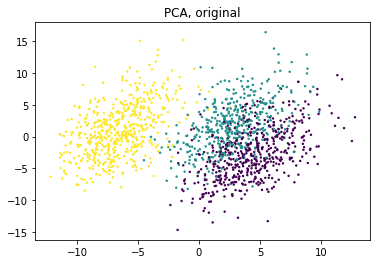

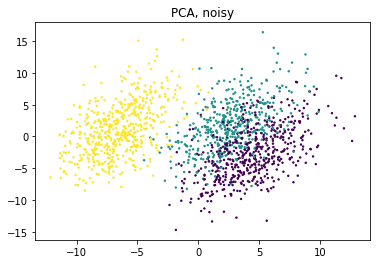

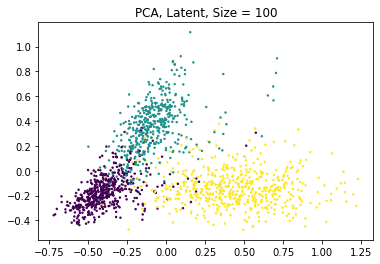

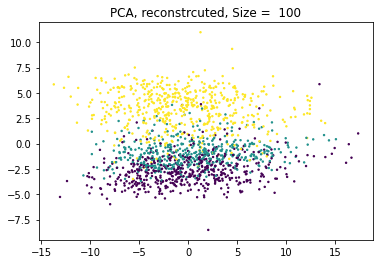

In [33]:
#Original, zinb noisy, PCA, tSNE for denoising_model5
dataset_test_loader_for_plot = DataLoader(dataset_test)
data_x_out = []
data_x_in = []
data_x_latent = []
data_y_out = []
data_noisy = []
with torch.no_grad():
    for _, (x, label) in enumerate(dataset_test_loader_for_plot):
        data_x_in.append(x)
        data_y_out.append(int(label))
        data_x_latent.append(zinb_denoising_model5(x)[0])
        data_x_out.append(zinb_denoising_model5(x)[1])
          
original_data = np.array([data_x_in[i].cpu().detach().numpy()[0] for i in range(len(data_x_in))])
data_noisy = torch.tensor(original_data) + ZINB(zero_probabilty=0.5, distribution_total_count=100, distribution_probability=0.1, linear_size=original_data.shape[0] * original_data.shape[1]).reshape(original_data.shape) / 100
encoded_data = np.array([data_x_latent[i].cpu().detach().numpy()[0] for i in range(len(data_x_latent))])
recosntructed_data = np.array([data_x_out[i].cpu().detach().numpy()[0] for i in range(len(data_x_out))])


#PCA for original
pca = PCA(n_components=2)
original_data_pca = pca.fit_transform(original_data)
plt.scatter(original_data_pca[:,0], original_data_pca[:,1], c=data_y_out, s=2)
plt.title(f'PCA, original')
plt.show()

#PCA for noisy
pca = PCA(n_components=2)
data_noisy_pca = pca.fit_transform(data_noisy)
plt.scatter(data_noisy_pca[:,0], data_noisy_pca[:,1], c=data_y_out, s=2)
plt.title(f'PCA, noisy')
plt.show()

#PCA for encoded
pca = PCA(n_components=2)
encoded_pca_data = pca.fit_transform(encoded_data)
plt.scatter(encoded_pca_data[:,0], encoded_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, Latent, Size = 100')
plt.show()

#PCA for reconstructed
pca = PCA(n_components=2)
reconstructed_pca_data = pca.fit_transform(recosntructed_data)
plt.scatter(reconstructed_pca_data[:,0], reconstructed_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, reconstrcuted, Size =  100')
plt.show()

/Users/husseinjafarinia/venvs/ML_For_Bio/lib/python3.10/site-packages/torch/distributions/distribution.py:159: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


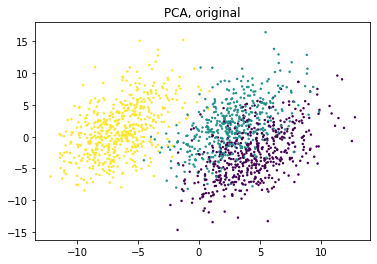

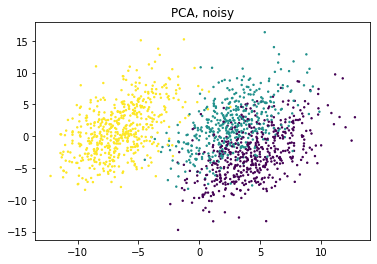

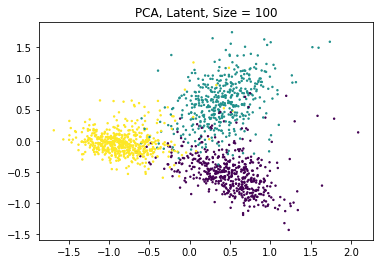

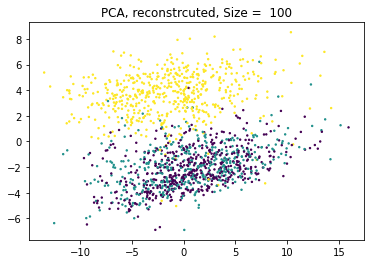

In [34]:
#Original, zinb noisy, PCA, tSNE for denoising_model10
dataset_test_loader_for_plot = DataLoader(dataset_test)
data_x_out = []
data_x_in = []
data_x_latent = []
data_y_out = []
data_noisy = []
with torch.no_grad():
    for _, (x, label) in enumerate(dataset_test_loader_for_plot):
        data_x_in.append(x)
        data_y_out.append(int(label))
        data_x_latent.append(zinb_denoising_model10(x)[0])
        data_x_out.append(zinb_denoising_model10(x)[1])
          
original_data = np.array([data_x_in[i].cpu().detach().numpy()[0] for i in range(len(data_x_in))])
data_noisy = torch.tensor(original_data) + ZINB(zero_probabilty=0.5, distribution_total_count=100, distribution_probability=0.1, linear_size=original_data.shape[0] * original_data.shape[1]).reshape(original_data.shape) / 100
encoded_data = np.array([data_x_latent[i].cpu().detach().numpy()[0] for i in range(len(data_x_latent))])
recosntructed_data = np.array([data_x_out[i].cpu().detach().numpy()[0] for i in range(len(data_x_out))])


#PCA for original
pca = PCA(n_components=2)
original_data_pca = pca.fit_transform(original_data)
plt.scatter(original_data_pca[:,0], original_data_pca[:,1], c=data_y_out, s=2)
plt.title(f'PCA, original')
plt.show()

#PCA for noisy
pca = PCA(n_components=2)
data_noisy_pca = pca.fit_transform(data_noisy)
plt.scatter(data_noisy_pca[:,0], data_noisy_pca[:,1], c=data_y_out, s=2)
plt.title(f'PCA, noisy')
plt.show()

#PCA for encoded
pca = PCA(n_components=2)
encoded_pca_data = pca.fit_transform(encoded_data)
plt.scatter(encoded_pca_data[:,0], encoded_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, Latent, Size = 100')
plt.show()

#PCA for reconstructed
pca = PCA(n_components=2)
reconstructed_pca_data = pca.fit_transform(recosntructed_data)
plt.scatter(reconstructed_pca_data[:,0], reconstructed_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, reconstrcuted, Size =  100')
plt.show()

/Users/husseinjafarinia/venvs/ML_For_Bio/lib/python3.10/site-packages/torch/distributions/distribution.py:159: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


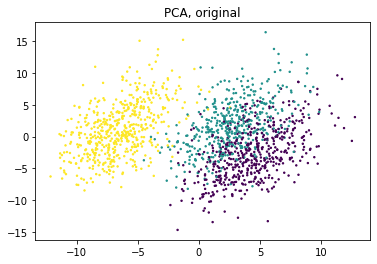

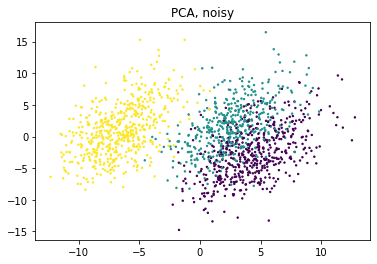

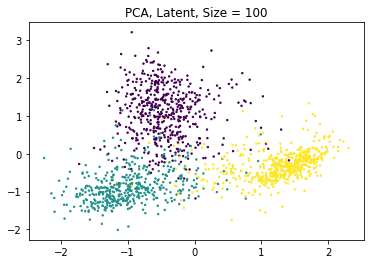

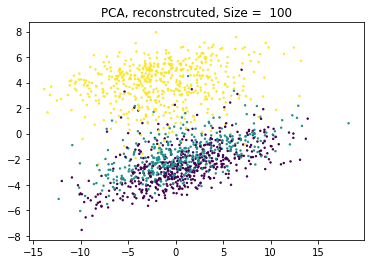

In [35]:
#Original, zinb noisy, PCA, tSNE for denoising_model50
dataset_test_loader_for_plot = DataLoader(dataset_test)
data_x_out = []
data_x_in = []
data_x_latent = []
data_y_out = []
data_noisy = []
with torch.no_grad():
    for _, (x, label) in enumerate(dataset_test_loader_for_plot):
        data_x_in.append(x)
        data_y_out.append(int(label))
        data_x_latent.append(zinb_denoising_model50(x)[0])
        data_x_out.append(zinb_denoising_model50(x)[1])
          
original_data = np.array([data_x_in[i].cpu().detach().numpy()[0] for i in range(len(data_x_in))])
data_noisy = torch.tensor(original_data) + ZINB(zero_probabilty=0.5, distribution_total_count=100, distribution_probability=0.1, linear_size=original_data.shape[0] * original_data.shape[1]).reshape(original_data.shape) / 100
encoded_data = np.array([data_x_latent[i].cpu().detach().numpy()[0] for i in range(len(data_x_latent))])
recosntructed_data = np.array([data_x_out[i].cpu().detach().numpy()[0] for i in range(len(data_x_out))])


#PCA for original
pca = PCA(n_components=2)
original_data_pca = pca.fit_transform(original_data)
plt.scatter(original_data_pca[:,0], original_data_pca[:,1], c=data_y_out, s=2)
plt.title(f'PCA, original')
plt.show()

#PCA for noisy
pca = PCA(n_components=2)
data_noisy_pca = pca.fit_transform(data_noisy)
plt.scatter(data_noisy_pca[:,0], data_noisy_pca[:,1], c=data_y_out, s=2)
plt.title(f'PCA, noisy')
plt.show()

#PCA for encoded
pca = PCA(n_components=2)
encoded_pca_data = pca.fit_transform(encoded_data)
plt.scatter(encoded_pca_data[:,0], encoded_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, Latent, Size = 100')
plt.show()

#PCA for reconstructed
pca = PCA(n_components=2)
reconstructed_pca_data = pca.fit_transform(recosntructed_data)
plt.scatter(reconstructed_pca_data[:,0], reconstructed_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, reconstrcuted, Size =  100')
plt.show()

/Users/husseinjafarinia/venvs/ML_For_Bio/lib/python3.10/site-packages/torch/distributions/distribution.py:159: UserWarning: sample_n will be deprecated. Use .sample((n,)) instead
  warnings.warn('sample_n will be deprecated. Use .sample((n,)) instead', UserWarning)


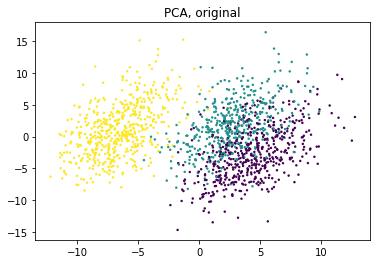

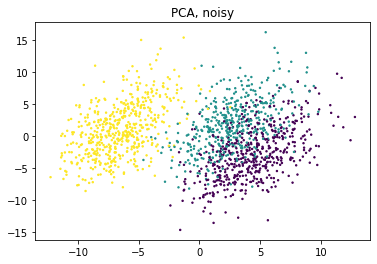

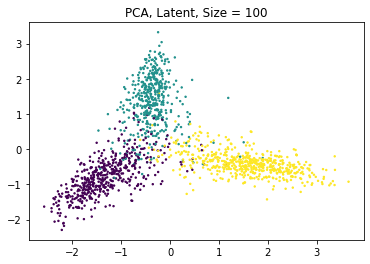

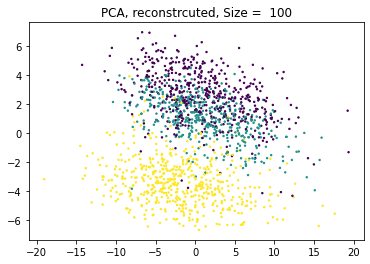

In [36]:
#Original, zinb noisy, PCA, tSNE for denoising_model100
dataset_test_loader_for_plot = DataLoader(dataset_test)
data_x_out = []
data_x_in = []
data_x_latent = []
data_y_out = []
data_noisy = []
with torch.no_grad():
    for _, (x, label) in enumerate(dataset_test_loader_for_plot):
        data_x_in.append(x)
        data_y_out.append(int(label))
        data_x_latent.append(zinb_denoising_model100(x)[0])
        data_x_out.append(zinb_denoising_model100(x)[1])
          
original_data = np.array([data_x_in[i].cpu().detach().numpy()[0] for i in range(len(data_x_in))])
data_noisy = torch.tensor(original_data) + ZINB(zero_probabilty=0.5, distribution_total_count=100, distribution_probability=0.1, linear_size=original_data.shape[0] * original_data.shape[1]).reshape(original_data.shape) / 100
encoded_data = np.array([data_x_latent[i].cpu().detach().numpy()[0] for i in range(len(data_x_latent))])
recosntructed_data = np.array([data_x_out[i].cpu().detach().numpy()[0] for i in range(len(data_x_out))])


#PCA for original
pca = PCA(n_components=2)
original_data_pca = pca.fit_transform(original_data)
plt.scatter(original_data_pca[:,0], original_data_pca[:,1], c=data_y_out, s=2)
plt.title(f'PCA, original')
plt.show()

#PCA for noisy
pca = PCA(n_components=2)
data_noisy_pca = pca.fit_transform(data_noisy)
plt.scatter(data_noisy_pca[:,0], data_noisy_pca[:,1], c=data_y_out, s=2)
plt.title(f'PCA, noisy')
plt.show()

#PCA for encoded
pca = PCA(n_components=2)
encoded_pca_data = pca.fit_transform(encoded_data)
plt.scatter(encoded_pca_data[:,0], encoded_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, Latent, Size = 100')
plt.show()

#PCA for reconstructed
pca = PCA(n_components=2)
reconstructed_pca_data = pca.fit_transform(recosntructed_data)
plt.scatter(reconstructed_pca_data[:,0], reconstructed_pca_data[:,1], c=data_y_out, s=2)
plt.title(f'PCA, reconstrcuted, Size =  100')
plt.show()

As we can see in plots generally for both Guassian noise and ZINB noie cases the denoising autoencoder is able to deniose and do what autoencoders are best too.

In [37]:
torch.save(model100, 'PART1_model_NoNoise.pt') #-> https://drive.google.com/file/d/1teZvffDX4GzSoNNtMtvIKCyLZAe3fxvv/view?usp=sharing
torch.save(denoising_model10, 'PART1_model_Normal_Denoising.pt') #-> https://drive.google.com/file/d/1c9-iWkOOHLxLQtaCSDCT9MuYDO3D2QwZ/view?usp=sharing
torch.save(zinb_denoising_model5, 'PART1_model_ZINB_Denoising.pt') #-> https://drive.google.com/file/d/1Ps1vC7LobKs7uCAuUVLJ5lW_yu58LgAh/view?usp=sharing